In [51]:
import json
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error, roc_auc_score

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [17]:
def get_best_parameters(X_train, y_train, max_evals=128):                

    kf = KFold(n_splits=5, shuffle=True, random_state=17)
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 5),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0, 1),
        'booster': hp.choice('booster', ['gbtree']),
        'gamma': hp.uniform('gamma', 0, 0.50),
        'min_child_weight': hp.uniform('min_child_weight', 0, 10),
        'subsample': hp.uniform('subsample', 0, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
        'reg_alpha': hp.uniform('reg_alpha', 0, 5),
        'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    }

    def train_XGBoost(space):
    
        model = XGBRegressor(
            n_estimators      = int(space['n_estimators']),
            max_depth         = int(space['max_depth']),
            learning_rate     = space['learning_rate'],
            booster           = space['booster'],
            gamma             = space['gamma'],
            min_child_weight  = space['min_child_weight'],
            subsample         = space['subsample'],
            colsample_bytree  = space['colsample_bytree'],
            reg_alpha         = space['reg_alpha'],
            reg_lambda        = space['reg_lambda'],
            eval_metric       = 'rmse',
            random_state      = 17)

        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

        return{
            'loss': -np.mean(scores), 
            'loss_variance': np.var(scores, ddof=1),
            'status': STATUS_OK}

    best_hyperparameters = fmin(
        fn=train_XGBoost,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        early_stop_fn=no_progress_loss(20)
        )
    
    best_params = space_eval(space, best_hyperparameters)

    return best_params

In [30]:
def get_model(best_params, X_train, y_train):
    
    model = XGBRegressor(
        n_estimators      = int(best_params['n_estimators']),
        max_depth         = int(best_params['max_depth']),
        learning_rate     = best_params['learning_rate'],
        booster           = best_params['booster'],
        gamma             = best_params['gamma'],
        min_child_weight  = best_params['min_child_weight'],
        subsample         = best_params['subsample'],
        colsample_bytree  = best_params['colsample_bytree'],
        reg_alpha         = best_params['reg_alpha'],
        reg_lambda        = best_params['reg_lambda'],
        objective         = 'reg:squarederror',
        eval_metric       = 'rmse',
        random_state      = 17)

    model.fit(X_train, y_train)
    
    return model

In [31]:
def evaluate_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    shap.summary_plot(shap_values, X_test, max_display=200, plot_type='bar', show=False, sort=True)

In [3]:
try:
    
    ###############################################################################################
    status = 'Loading config ...'
    print('{} -> {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), status))
    with open('config/config.json') as config:
        config = json.load(config)
    status = 'Loading config done!'
    print('{} -> {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), status))
    ###############################################################################################
    
    ###############################################################################################
    status = 'Getting raw dataset ...'
    print('{} -> {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), status))
    df = pd.read_csv('data/outputs/dataset_{}_{}.csv'.format(config['seasons'][0], config['seasons'][-1]))
    status = 'Getting raw dataset done!'
    print('{} -> {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), status))
    ###############################################################################################
    
except Exception as e:
    print('Exception: {}'.format(e))
    print('Errored out during: {}'.format(status))

2022-01-23 18:06:53 -> Loading config ...
2022-01-23 18:06:53 -> Loading config done!
2022-01-23 18:06:53 -> Getting raw dataset ...
2022-01-23 18:06:54 -> Getting raw dataset done!


In [4]:
df.head()

,match_id,date,player_id,player,team,home_team,away_team,is_home,season,month,day,hour,week_day,position,G90P,A90P,s90P,xG90P,xA90P,time,G90T,GC90T,xG90T,xGC90T,G90OT,GC90OT,xG90OT,xGC90OT,target
0,5149,2014-08-30,1344,Nicolas Frey,Chievo,Chievo,Juventus,1,2014,8,30,17,5,DR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5149,2014-08-30,1572,Bostjan Cesar,Chievo,Chievo,Juventus,1,2014,8,30,17,5,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5149,2014-08-30,1331,Dario Dainelli,Chievo,Chievo,Juventus,1,2014,8,30,17,5,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5149,2014-08-30,1164,Cristiano Biraghi,Chievo,Chievo,Juventus,1,2014,8,30,17,5,DL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5149,2014-08-30,1334,Perparim Hetemaj,Chievo,Chievo,Juventus,1,2014,8,30,17,5,MC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
metadata_columns=['match_id', 'date', 'player_id', 'player']
categorical_columns=['team', 'home_team', 'away_team', 'position']
numerical_columns = [x for x in list(df.columns) if (x not in metadata_columns) and (x not in categorical_columns)]

In [6]:
numerical_df = df[numerical_columns]

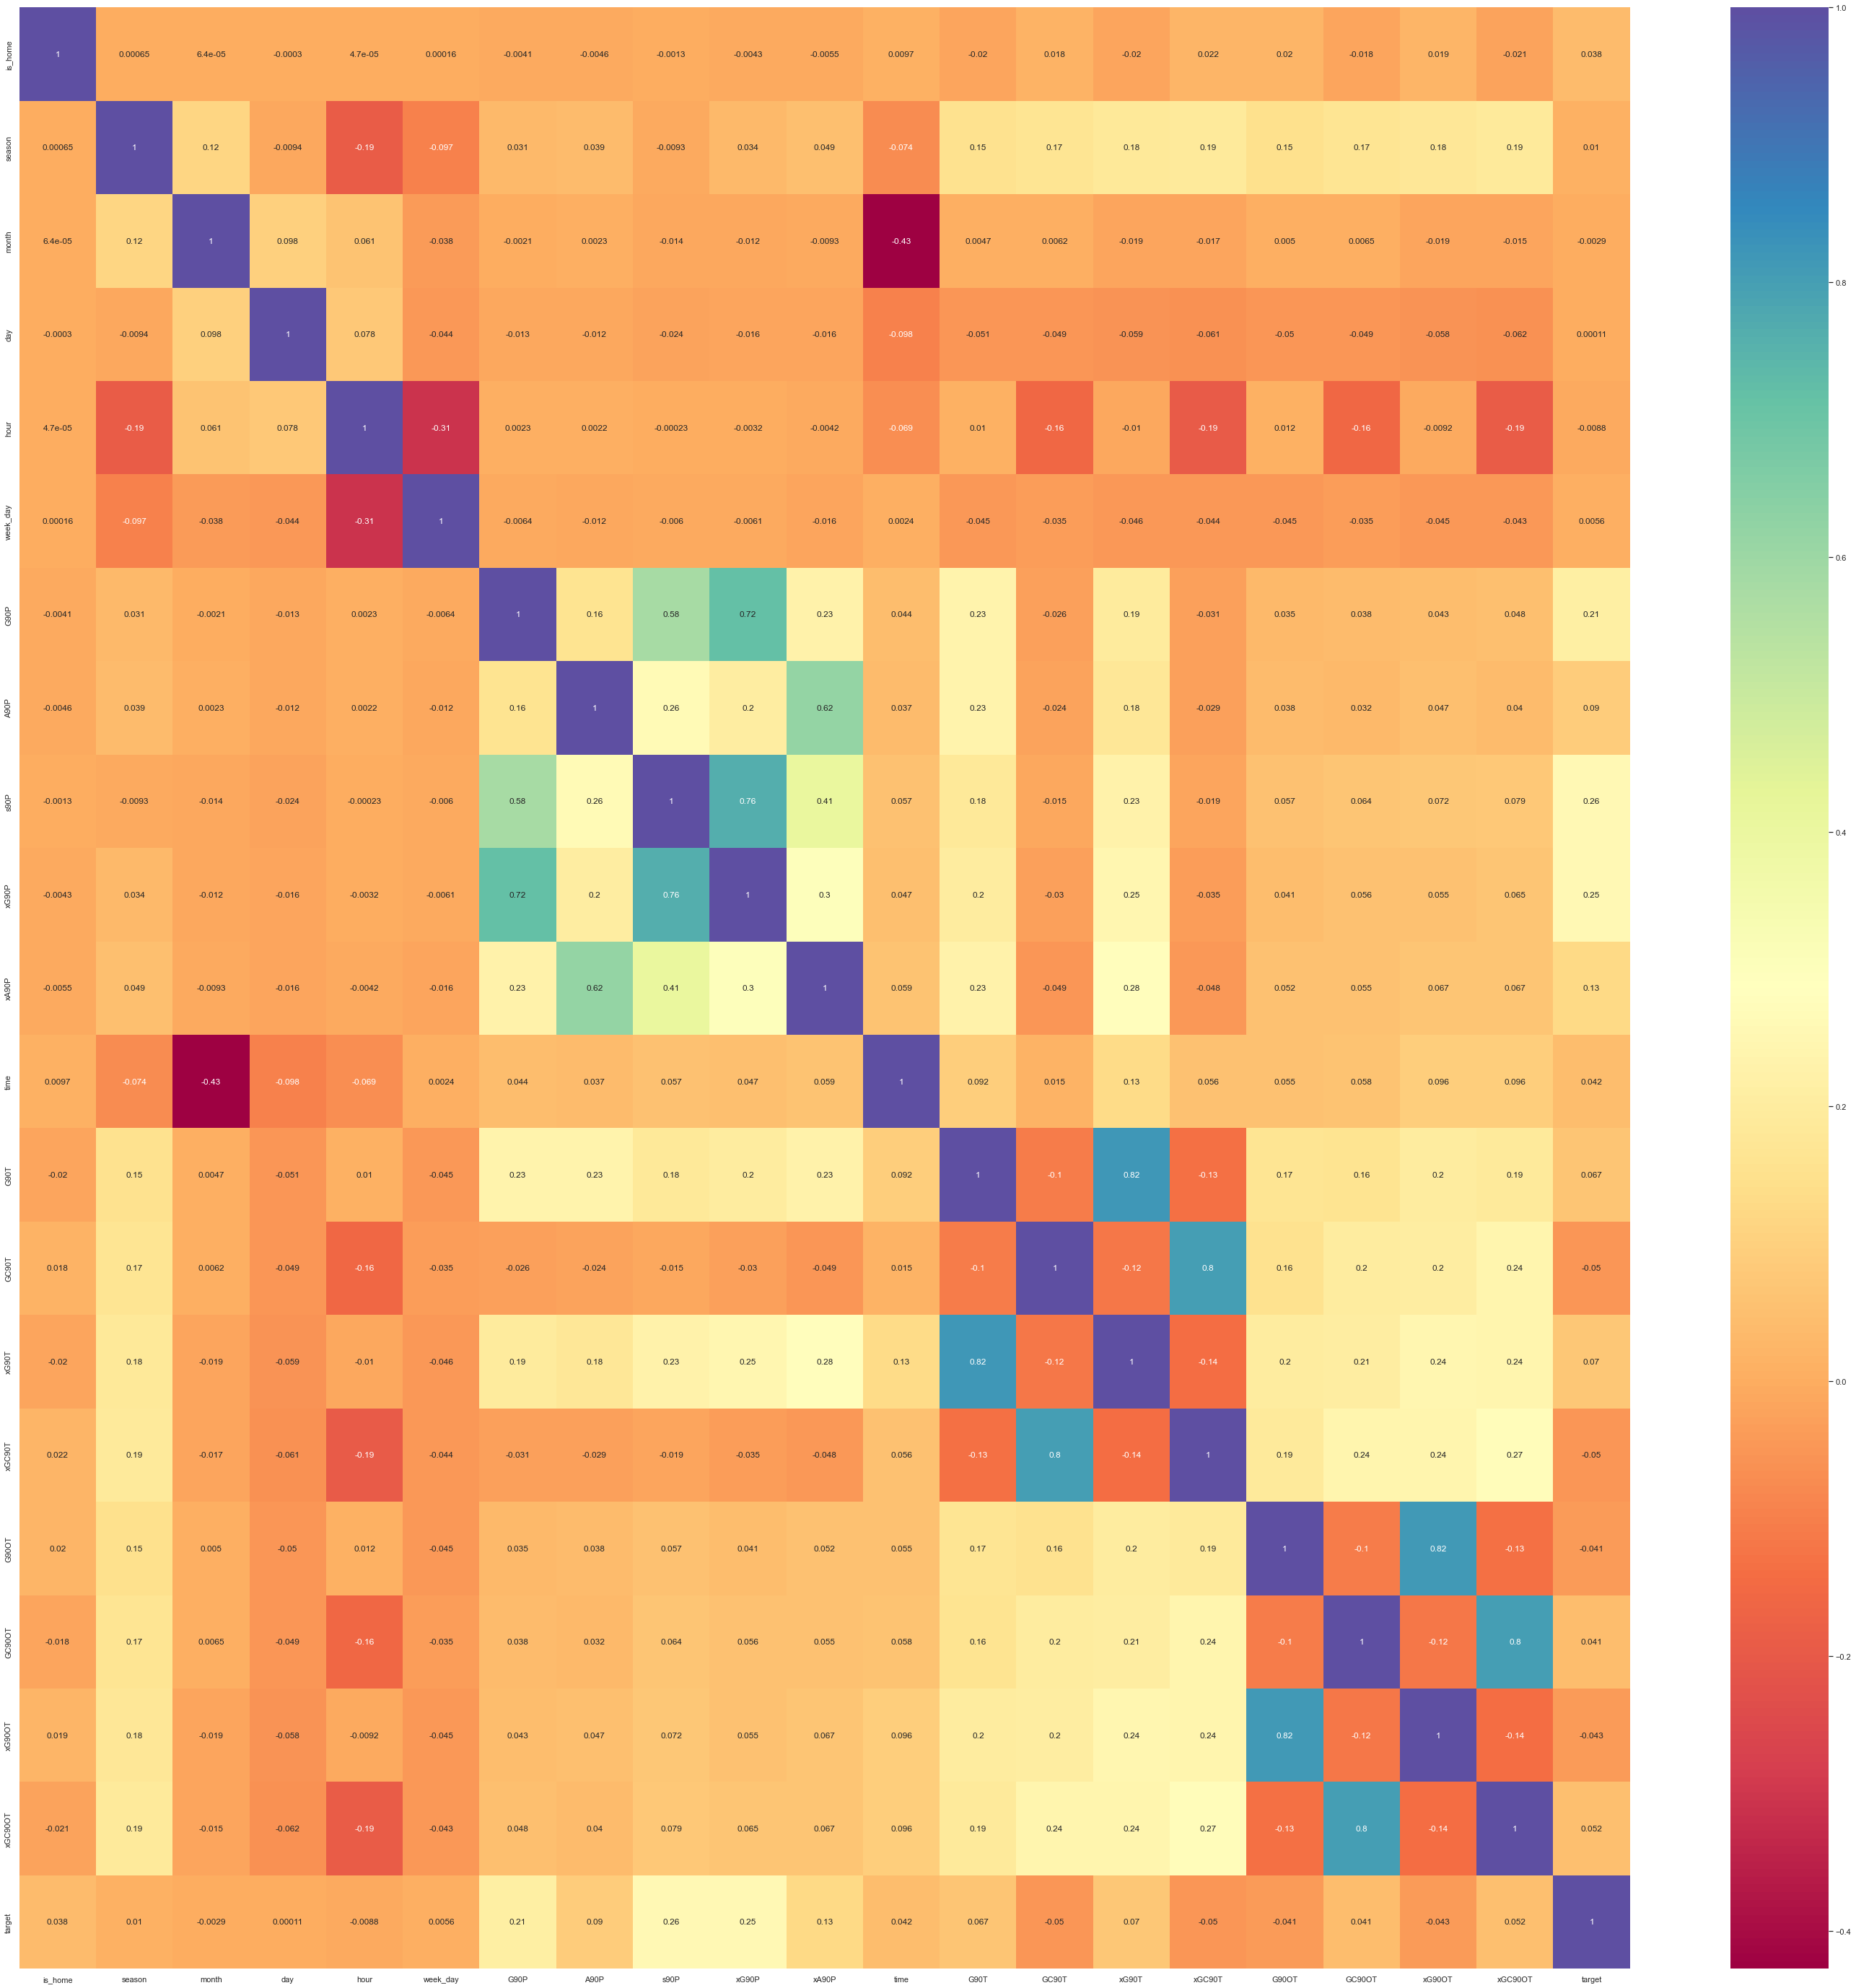

In [7]:
corr_matrix = numerical_df.corr()
sns.set(rc={'figure.figsize':(50, 50)})
sns.heatmap(corr_matrix, cmap='Spectral', annot=True)
plt.show()

In [8]:
correlated_features = corr_matrix.where(corr_matrix.abs().gt(0.5)).reset_index().melt('index').dropna()
correlated_features.rename(columns={'index': 'Variable_1', 'variable': 'Variable_2', 'value': 'Correlation'}, inplace=True)
correlated_features = correlated_features[correlated_features.Variable_1 != correlated_features.Variable_2].sort_values(by='Correlation', key=abs)
correlated_features = correlated_features.reset_index()
correlated_features = correlated_features[correlated_features.index % 2 == 0]
correlated_features

,index,Variable_1,Variable_2,Correlation
0,134,s90P,G90P,0.578610
2,157,xA90P,A90P,0.616862
4,135,xG90P,G90P,0.719118
6,177,xG90P,s90P,0.763008
8,288,xGC90T,GC90T,0.802685
10,376,xGC90OT,GC90OT,0.803355
12,354,xG90OT,G90OT,0.815364
14,266,xG90T,G90T,0.816437


In [9]:
uncorrelated_features = corr_matrix.where(corr_matrix.abs().lt(0.1)).reset_index().melt('index').dropna()
uncorrelated_features.rename(columns={'index': 'Variable_1', 'variable': 'Variable_2', 'value': 'Correlation'}, inplace=True)
uncorrelated_features = uncorrelated_features[uncorrelated_features.Variable_1 != uncorrelated_features.Variable_2].sort_values(by='Correlation', key=abs)
uncorrelated_features = uncorrelated_features[uncorrelated_features.Variable_2 == 'target'].sort_values(by='Correlation', key=abs)
uncorrelated_features

,Variable_1,Variable_2,Correlation
423,day,target,0.000113
422,month,target,-0.002897
425,week_day,target,0.005642
424,hour,target,-0.008804
421,season,target,0.010127
420,is_home,target,0.037604
437,GC90OT,target,0.040938
436,G90OT,target,-0.041279
431,time,target,0.042261
438,xG90OT,target,-0.042697


In [10]:
uncorrelated_features = corr_matrix.where(corr_matrix.abs().gt(0.1)).reset_index().melt('index').dropna()
uncorrelated_features.rename(columns={'index': 'Variable_1', 'variable': 'Variable_2', 'value': 'Correlation'}, inplace=True)
uncorrelated_features = uncorrelated_features[uncorrelated_features.Variable_1 != uncorrelated_features.Variable_2].sort_values(by='Correlation', key=abs)
uncorrelated_features = uncorrelated_features[uncorrelated_features.Variable_2 == 'target'].sort_values(by='Correlation', key=abs)
uncorrelated_features

,Variable_1,Variable_2,Correlation
430,xA90P,target,0.129969
426,G90P,target,0.208862
429,xG90P,target,0.253032
428,s90P,target,0.257631


In [11]:
to_drop = ['season', 'month', 'day', 'hour', 'week_day']

In [12]:
df = df.drop(columns=to_drop)

In [13]:
df['opponent'] = df['home_team']
df.loc[df['is_home'] == 1, 'opponent'] = df['away_team']
df.head()

,match_id,date,player_id,player,team,home_team,away_team,is_home,position,G90P,A90P,s90P,xG90P,xA90P,time,G90T,GC90T,xG90T,xGC90T,G90OT,GC90OT,xG90OT,xGC90OT,target,opponent
0,5149,2014-08-30,1344,Nicolas Frey,Chievo,Chievo,Juventus,1,DR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Juventus
1,5149,2014-08-30,1572,Bostjan Cesar,Chievo,Chievo,Juventus,1,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Juventus
2,5149,2014-08-30,1331,Dario Dainelli,Chievo,Chievo,Juventus,1,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Juventus
3,5149,2014-08-30,1164,Cristiano Biraghi,Chievo,Chievo,Juventus,1,DL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Juventus
4,5149,2014-08-30,1334,Perparim Hetemaj,Chievo,Chievo,Juventus,1,MC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Juventus
